# Corrección de la predicción (Series temporales Forex)


## 1 Objetivo 


A lo largo de este notebook, voy a hacer el desarrollo del modelo ML que toma la salida del predictor de precios HIGH,LOW y en base a esa predicción y al error cometido en las N sesiones anteriores (N=4), genera un factor de corrección a aplicar sobre dicha predicción, para que ésta se ajuste mejor al objetivo perseguido.


## 2 Preparación

A continuación iré describiendo los pasos que he llevado a cabo para implementar el modelo neuronal comentado.

### Carga de librerías

En primer lugar cargamos las librerías que vamos a utilizar. Las más significativas son:

- Numpy, Pandas, Scikit-Learn, Matplotlib & Seaborn
- Keras como librería ML sobre Tensorflow
- Talib como librería fintech
- MyUtils, una librería propia donde tengo un poco de todo: desde implementaciones neuronales, partición de pares de entrenamiento y test, visualización, backup de archivos en disco, etc...

In [1]:
import sys
sys.path.append('../..')

####################################################################################
# Librerías de manejo de datos 
import pandas as pd
from pandas import concat
from pandas.plotting import scatter_matrix
import numpy as np

####################################################################################
# Librerías de machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
import keras
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm
from keras.wrappers.scikit_learn import KerasClassifier

####################################################################################
# Librerías de visualización
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator, WeekdayLocator, date2num)
import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls
tls.set_credentials_file(username='raulMrello', api_key='qX9S30YRQ866mGF9b89u')

####################################################################################
# TA-Lib: instalación y carga de la librería
import talib

####################################################################################
# Otras utilidades
import datetime
import time
import os
import sys
import math

Using TensorFlow backend.


In [2]:
import common.MyUtils as utils
print('Ready!')

Ready!


### Obtención del dataframe de salida del Predictor

En primer lugar, cargo el dataframe obtenido del modelo anterior (Predictor de precios). Es un dataframe que ya está preparado y que únicamente necesita reajustar el formato del índice a un tipo pandas.Timestamp.

In [3]:
# Cargo el histórico en el dataframe 'df' y visualizo los primeros registros
df = pd.read_csv('../csv_data/predictive_output.csv', sep=';', index_col=0)
df.index = pd.to_datetime(df.index)
print('Type of index values:',df.index.dtype)
df.head()


Type of index values: datetime64[ns]


,ERROR_HIGH(t-4),ERROR_LOW(t-4),ERROR_HIGH(t-3),ERROR_LOW(t-3),ERROR_HIGH(t-2),ERROR_LOW(t-2),ERROR_HIGH(t-1),ERROR_LOW(t-1),ERROR_HIGH,ERROR_LOW,PREDICT_HIGH,PREDICT_LOW,TARGET_HIGH,TARGET_LOW
2015-03-13 13:00:00,0.001101,0.002080,-0.001075,-0.000046,-0.000572,-0.000506,-0.000015,0.000533,0.002103,0.002294,1.057727,1.054256,1.05983,1.05655
2015-03-13 14:00:00,-0.001075,-0.000046,-0.000572,-0.000506,-0.000015,0.000533,0.002103,0.002294,-0.001138,-0.002879,1.059488,1.055879,1.05835,1.05300
2015-03-13 15:00:00,-0.000572,-0.000506,-0.000015,0.000533,0.002103,0.002294,-0.001138,-0.002879,-0.000705,-0.000351,1.054705,1.050671,1.05400,1.05032
2015-03-13 16:00:00,-0.000015,0.000533,0.002103,0.002294,-0.001138,-0.002879,-0.000705,-0.000351,-0.000343,-0.001085,1.052883,1.049255,1.05254,1.04817
2015-03-13 17:00:00,0.002103,0.002294,-0.001138,-0.002879,-0.000705,-0.000351,-0.000343,-0.001085,-0.000383,0.000452,1.053593,1.050448,1.05321,1.05090


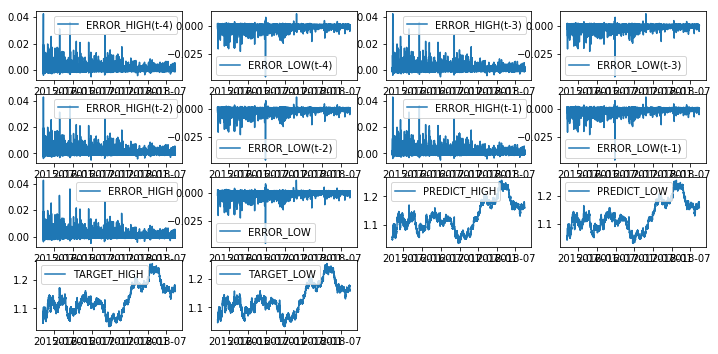

In [4]:
# Visualizo gráficamente todos los 'features' que forman el dataframe 'df', incluyendo las salidas a predecir (ERROR_HIGH,ERROR_LOW)
rows = (df.shape[1] / 2) + 1
plt.figure(figsize = (12,12))
for c in df.columns:
  i = df.columns.get_loc(c)+1
  plt.subplot(rows, 4, i)
  plt.plot(df[c])
  plt.legend([c])

### Adaptación de los datos al modelo neuronal

El modelo neuronal que planteo es de nuevo una red neuronal tipo LSTM ya que hace uso de la memoria temporal de las últimas N muestras para predecir la corrección a aplicar, por lo tanto, los features a utilizar en este modelo serán:

- ERROR_HIGH(t-i)
- ERROR_LOW(t-i)

Y las salidas serán:

- ERROR_HIGH
- ERROR_LOW

Una vez entrenado el modelo, se utilizarán las salidas para corregir los valores de PREDICTIVE_HIGH y PREDICTIVE_LOW y ver si el error de la predicción final mejora respecto del modelo predictivo anterior.

In [5]:
# Defino el formato del dataframe 'df_nn' que voy a obtener como proceso de adaptación. Es necesario definir las siguientes
# variables que se utilizarán a lo largo del desarrollo

# Número de salidas a predecir
num_outputs = 2

# Número de 'features' de entrada
num_inputs = 2

# Número de timesteps previos
n_in = 4

# Número de timesteps a futuro
n_out = 1

# Obtengo el dataframe de trabajo para el entrenamiento con la red neuronal
df_nn = df.drop(columns=['PREDICT_HIGH', 'PREDICT_LOW', 'TARGET_HIGH', 'TARGET_LOW'])

print(df_nn.shape)
df_nn.head()

(22211, 10)


,ERROR_HIGH(t-4),ERROR_LOW(t-4),ERROR_HIGH(t-3),ERROR_LOW(t-3),ERROR_HIGH(t-2),ERROR_LOW(t-2),ERROR_HIGH(t-1),ERROR_LOW(t-1),ERROR_HIGH,ERROR_LOW
2015-03-13 13:00:00,0.001101,0.002080,-0.001075,-0.000046,-0.000572,-0.000506,-0.000015,0.000533,0.002103,0.002294
2015-03-13 14:00:00,-0.001075,-0.000046,-0.000572,-0.000506,-0.000015,0.000533,0.002103,0.002294,-0.001138,-0.002879
2015-03-13 15:00:00,-0.000572,-0.000506,-0.000015,0.000533,0.002103,0.002294,-0.001138,-0.002879,-0.000705,-0.000351
2015-03-13 16:00:00,-0.000015,0.000533,0.002103,0.002294,-0.001138,-0.002879,-0.000705,-0.000351,-0.000343,-0.001085
2015-03-13 17:00:00,0.002103,0.002294,-0.001138,-0.002879,-0.000705,-0.000351,-0.000343,-0.001085,-0.000383,0.000452


### Normalización de los datos

A la hora de utilizar los datos como entrada del modelo neuronal, es necesario que todos estén en el mismo factor de escala o que tengan valores en un rango similar, de forma que facilite el entrenamiento del modelo.

Para ello utilizo la librería 'sklearn' con el scaler 'MinMaxScaler' que permite reajustar diferentes conjuntos de datos de una sola vez.

El 'scaler' resultante deberé guardarlo para reutilizarlo en el proceso inverso de de-normalización, para obtener los valores reales predichos.

In [6]:
#### Normalización de los datos sobre el datafram 'df_nn'. Genero un nuevo dataframe 'dfnorm'
dfnorm, scaler = utils.normalize_data(df_nn)
# Verifico los datos del nuevo dataframe generado
dfnorm.describe()

,ERROR_HIGH(t-4),ERROR_LOW(t-4),ERROR_HIGH(t-3),ERROR_LOW(t-3),ERROR_HIGH(t-2),ERROR_LOW(t-2),ERROR_HIGH(t-1),ERROR_LOW(t-1),ERROR_HIGH,ERROR_LOW
count,22211.000000,22211.000000,22211.000000,22211.000000,22211.000000,22211.000000,22211.000000,22211.000000,22211.000000,22211.000000
mean,-0.787173,0.624908,-0.787175,0.624906,-0.787173,0.624907,-0.787173,0.624909,-0.787171,0.624911
std,0.060503,0.047412,0.060503,0.047411,0.060502,0.047411,0.060502,0.047410,0.060502,0.047411
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.814541,0.616478,-0.814541,0.616478,-0.814539,0.616486,-0.814539,0.616492,-0.814539,0.616492
50%,-0.800363,0.636291,-0.800363,0.636285,-0.800360,0.636291,-0.800360,0.636291,-0.800360,0.636294
75%,-0.777878,0.647518,-0.777885,0.647516,-0.777885,0.647516,-0.777885,0.647516,-0.777878,0.647518
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3 Construcción del modelo neuronal

En primer lugar, como ya dije, voy a utilizar Keras como frontend sobre Tensorflow para construir una red neuronal recurrente basada en células LSTM.

Para realizar la implementación de la red utilizaré mi librería de utilidades con la función 'buil_lstm_net' que crea una red del tipo anterior con una serie de características ajustables como argumentos: número de entradas, salidas, timesteps hacia atrás y hacia adelante, número de capas, etc...

En primer lugar para verificar que el modelo es decente, realizaré una validación cruzada utilizando la librería 'sklearn' con la función 'Kfolds'.

Generaré 5 modelos diferentes con distintos conjuntos de entrenamiento y validación para obtener un 'score' medio del modelo que he seleccionado.

Si el modelo genera un 'score' decente, entrenaré el modelo para generar los pesos de la red neuronal que posteriormente guardaré en un archivo con formato HDF5.

Por lo tanto, resumiendo, los pasos a seguir son:

- Buscar una configuración del modelo adecuada con GridSearch
- Realizar una validación cruzada con el modelo seleccionado.
- Verificar si el 'score' medio es bueno y en ese caso, entrenar dicho modelo
- Verificar si el modelo se comporta bien con datos que nunca ha visto anteriormente
- Guardar los pesos de la red en un archivo HDF5

### Validación cruzada

Realizado un Kfolds y parametrizo los hiperparámetros a verificar.

In [7]:
# split into input (X) and output (Y) variables
X = dfnorm.values[:,:(num_inputs*n_in)]
Y = dfnorm.values[:,(num_inputs*n_in):]

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# define the grid search parameters
parameter_grid = {
                  'nll' : [2, 3],
                  'ndl' : [1, 2],
                  'nlc' : [32, 64],
                  'ndc' : [64, 128]
                  }

for params in list(ParameterGrid(parameter_grid)): 
  cvscores = []
  print('+-+-+-+-+-+-+-+-+-+-+--+')
  print('Evaluating:',params)
  for train, test in kfold.split(X, Y):
    model, callbacks = utils.build_lstm_net(num_inputs, n_in, num_outputs, n_out, 
                                            params['nll'],
                                            params['ndl'],
                                            params['nlc'],
                                            params['ndc'],
                                            'weights_0412_'+str(params['nll'])+'_'+str(params['ndl'])+'_'+str(params['nlc'])+'_'+str(params['ndc'])+'.hd5')
    i += 1
    # Fit the model
    x = X[train]
    x = x.reshape(x.shape[0], n_in, num_inputs)
    utils.fit(model, x, Y[train], num_inputs, n_in, num_epochs=5, callbacks=callbacks, batchsize=32)  
    # evaluate the model
    x = X[test]
    scores = utils.test_evaluation(model, x, Y[test], num_inputs, n_in)
    x = x.reshape(x.shape[0], n_in, num_inputs)
    scores = model.evaluate(x, Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
  


+-+-+-+-+-+-+-+-+-+-+--+
Evaluating: {'ndc': 64, 'ndl': 1, 'nlc': 32, 'nll': 2}


C:\Users\raulm\Programas\anaconda3\envs\keras\lib\site-packages\keras\callbacks.py:434: RuntimeWarning:

Can save best model only with val_acc available, skipping.



loss: 2.63%
acc: 99.98%
loss: 2.76%
acc: 100.00%
loss: 2.64%
acc: 99.98%
loss: 2.83%
acc: 99.95%
loss: 2.75%
acc: 99.98%
99.98% (+/- 0.01%)
+-+-+-+-+-+-+-+-+-+-+--+
Evaluating: {'ndc': 64, 'ndl': 1, 'nlc': 32, 'nll': 3}
loss: 2.61%
acc: 99.98%
loss: 2.75%
acc: 100.00%
loss: 2.65%
acc: 99.98%
loss: 2.84%
acc: 99.95%
loss: 2.73%
acc: 99.98%
99.98% (+/- 0.01%)
+-+-+-+-+-+-+-+-+-+-+--+
Evaluating: {'ndc': 64, 'ndl': 1, 'nlc': 64, 'nll': 2}
loss: 2.62%
acc: 99.98%
loss: 2.73%
acc: 100.00%
loss: 2.80%
acc: 99.98%
loss: 2.81%
acc: 99.95%
loss: 2.75%
acc: 99.98%
99.98% (+/- 0.01%)
+-+-+-+-+-+-+-+-+-+-+--+
Evaluating: {'ndc': 64, 'ndl': 1, 'nlc': 64, 'nll': 3}
loss: 2.72%
acc: 99.98%
loss: 2.87%
acc: 100.00%
loss: 2.69%
acc: 99.98%
loss: 2.98%
acc: 99.95%
loss: 2.72%
acc: 99.98%
99.98% (+/- 0.01%)
+-+-+-+-+-+-+-+-+-+-+--+
Evaluating: {'ndc': 64, 'ndl': 2, 'nlc': 32, 'nll': 2}
loss: 2.61%
acc: 99.98%
loss: 2.75%
acc: 100.00%
loss: 2.73%
acc: 99.98%
loss: 2.82%
acc: 99.95%
loss: 2.73%
acc: 99.98%

KeyboardInterrupt: 

### Entrenamiento

Viendo la validación cruzada, prácticamente todos los modelos se comportan igual, por lo tanto, voy a elegir el modelo con menos recursos computacionales:

- Num LSTM layers: 2
- Num LSTM neurons: 32
- Num Dense layers: 1
- Num Dense neurons: 64


In [8]:
# Preparo los conjuntos de entrenamiento y validación en una proporción del 80-20
x_train,y_train,x_test,y_test = utils.prepare_training_data(dfnorm, num_inputs * n_in, 0.8)
print('x_train:', x_train.shape, 'y_train', y_train.shape)
print('x_test:', x_test.shape, 'y_test', y_test.shape)


x_train: (17768, 8) y_train (17768, 2)
x_test: (4443, 8) y_test (4443, 2)


In [9]:
# Creo el mismo modelo neuronal utilizado durante la validación  cruzada
model,callbacks = utils.build_lstm_net(num_inputs, n_in, num_outputs, n_out, 2,1,32,64,'../hd5_data/weights_2.1.32.64.hd5')

Train on 14214 samples, validate on 3554 samples
Epoch 1/10
 - 2s - loss: 0.0354 - acc: 0.9996 - val_loss: 0.0201 - val_acc: 1.0000
Epoch 2/10
 - 2s - loss: 0.0329 - acc: 0.9996 - val_loss: 0.0203 - val_acc: 1.0000
Epoch 3/10
 - 2s - loss: 0.0315 - acc: 0.9996 - val_loss: 0.0205 - val_acc: 1.0000
Epoch 4/10
 - 2s - loss: 0.0308 - acc: 0.9996 - val_loss: 0.0200 - val_acc: 1.0000
Epoch 5/10
 - 2s - loss: 0.0304 - acc: 0.9996 - val_loss: 0.0203 - val_acc: 1.0000
Epoch 6/10
 - 2s - loss: 0.0303 - acc: 0.9996 - val_loss: 0.0200 - val_acc: 1.0000
Epoch 7/10
 - 2s - loss: 0.0302 - acc: 0.9996 - val_loss: 0.0199 - val_acc: 1.0000
Epoch 8/10
 - 2s - loss: 0.0302 - acc: 0.9996 - val_loss: 0.0204 - val_acc: 1.0000
Epoch 9/10
 - 2s - loss: 0.0301 - acc: 0.9996 - val_loss: 0.0199 - val_acc: 1.0000
Epoch 10/10
 - 2s - loss: 0.0301 - acc: 0.9996 - val_loss: 0.0199 - val_acc: 1.0000


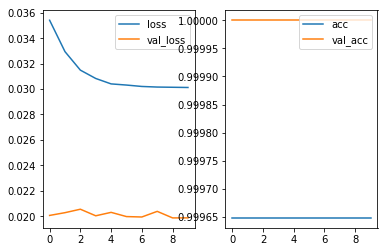

In [11]:
# Realizo el proceso de entrenamiento durante un número de épocas.
num_epochs = 10
# Tamaño del batch para la actualización de pesos
batchsize = 32
# Utilizo un 20% de los datos para realizar una validación
val_ratio = 0.2
# Cojo datos de forma aleatoria durante la fase de entrenamiento
shuffle = True
# Flag para visualizar los resultados al final del proceso
plot_results = True
# Función para iniciar el entrenamiento
result = utils.fit(model, x_train, y_train, num_inputs, n_in, num_epochs, callbacks, batchsize, val_ratio, shuffle, plot_results, verbose=2)

In [12]:
# Guardo los pesos en un archivo HDF5
model.save_weights('../hd5_data/weights_2.1.32.64.hd5')

### Verificación del modelo

Una vez que he entrenado el modelo, voy a verificar cómo se comportaría con datos que nunca ha visto previamente, para ello utilizo el subconjunto de test con mi librería de utilidades y la función 'test_rmse'.

Esta función, evalúa cada para X,Y de test y utiliza una callback 'out_builder' y el 'scaler' utilizado durante la normalización, para deshacer el escalado en los datos predichos y calcular cuál sería el valor real predicho de los precios HIGH,LOW y comparalos con los precios objetivo.

A partir de esas diferencias, se obtendrá el error RMSE para todo el conjunto de test.

Model Loss:  0.022144904403355967
Model Accuracy:  1.0


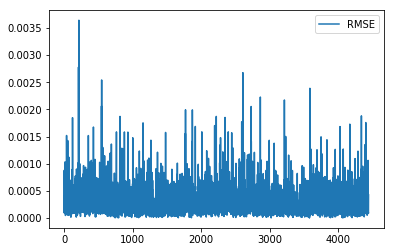

In [13]:
def out_builder(xy,xyhat):
  return xy,xyhat
  
scores, targets, preds, rmse = utils.test_rmse(model, x_test, y_test, num_inputs, n_in, num_outputs, n_out, scaler, out_builder, True)

In [15]:
# obtengo los resultados como arrays
atgt = np.asarray(targets)
apreds = np.asarray(preds)
armse = np.asarray(rmse)

# creo un nuevo dataframe de resultados 'df_corrections'
df_corrections = df_nn[x_train.shape[0]:].copy()

#... al que añado las predicciones hechas...
df_corrections['CORRECTION_HIGH'] = apreds[:,0]
df_corrections['CORRECTION_LOW'] = apreds[:,1]

#... las predicciones aplicando la corrección anterior 
df_corrections['PREDICT_FINAL_HIGH'] = apreds[:,0] + df[x_train.shape[0]:]['PREDICT_HIGH'].values
df_corrections['PREDICT_FINAL_LOW'] = apreds[:,1] + df[x_train.shape[0]:]['PREDICT_LOW'].values

df_corrections['TARGET_HIGH'] = df[x_train.shape[0]:]['TARGET_HIGH']
df_corrections['TARGET_LOW'] = df[x_train.shape[0]:]['TARGET_LOW'] 

df_corrections.head()

,ERROR_HIGH(t-4),ERROR_LOW(t-4),ERROR_HIGH(t-3),ERROR_LOW(t-3),ERROR_HIGH(t-2),ERROR_LOW(t-2),ERROR_HIGH(t-1),ERROR_LOW(t-1),ERROR_HIGH,ERROR_LOW,CORRECTION_HIGH,CORRECTION_LOW,PREDICT_FINAL_HIGH,PREDICT_FINAL_LOW,TARGET_HIGH,TARGET_LOW
2018-01-12 21:00:00,-0.000162,-0.001101,-0.000094,0.000743,0.002606,0.001090,0.001630,0.001103,0.000030,0.000901,-0.000162,-0.001101,1.218657,1.215669,1.21885,1.21767
2018-01-12 22:00:00,-0.000094,0.000743,0.002606,0.001090,0.001630,0.001103,0.000030,0.000901,0.002405,0.001473,-0.000094,0.000743,1.219361,1.217960,1.22186,1.21869
2018-01-12 23:00:00,0.002606,0.001090,0.001630,0.001103,0.000030,0.000901,0.002405,0.001473,0.000569,0.001068,0.002606,0.001090,1.222837,1.219262,1.22080,1.21924
2018-01-15 00:00:00,0.001630,0.001103,0.000030,0.000901,0.002405,0.001473,0.000569,0.001068,0.000213,0.000106,0.001630,0.001103,1.222577,1.220076,1.22116,1.21908
2018-01-15 01:00:00,0.000030,0.000901,0.002405,0.001473,0.000569,0.001068,0.000213,0.000106,-0.000014,0.000790,0.000030,0.000901,1.219945,1.218871,1.21990,1.21876


Con el nuevo dataframe de resultado 'df_corrections', realizo una visualización para ver cómo se ha comportado el modelo.

Visualizaré un rango de datos (i:j) de los objetivos H,L buscados y las predicciones reales generadas. El área entre los objetivos H-L se rellenerá en color gris, mientras que el área de las predicciones se rellenará en amarillo.

De esta forma, se puede ver claramente, si el rango de predicción es correcto y está alineado con el objetivo.

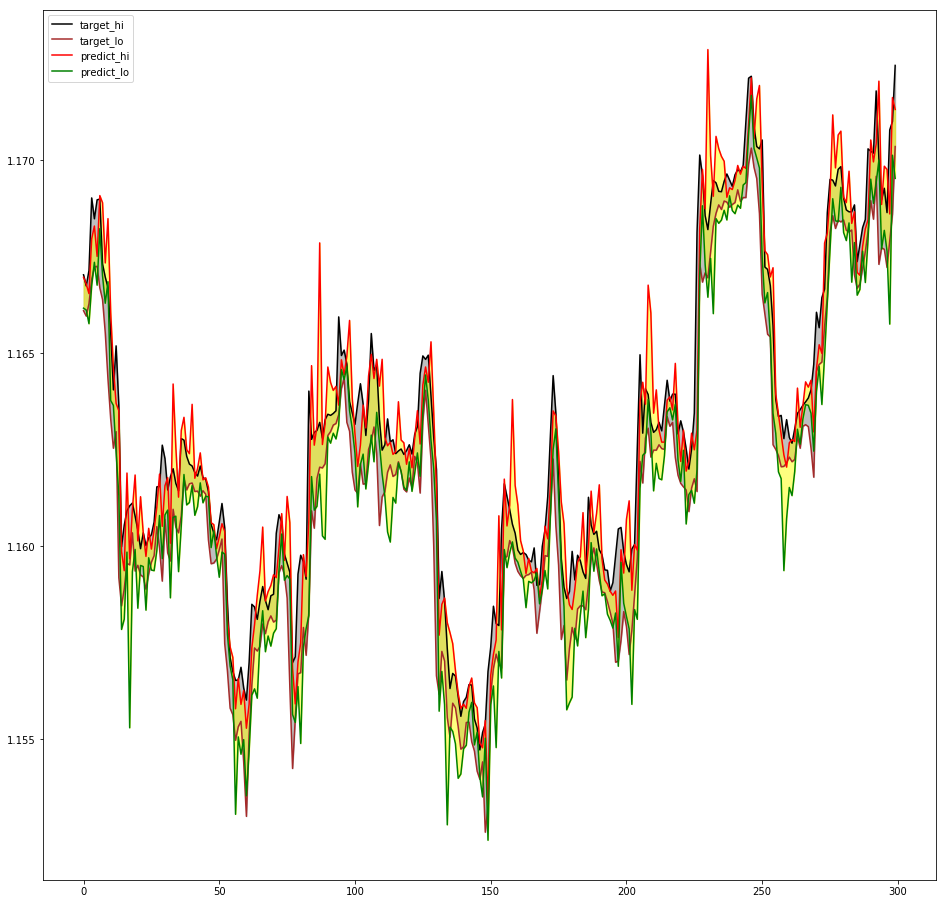

In [19]:
plt.figure(figsize=(16,16))
i,j=-500,-200
x = np.arange(j-i)
y1 = df_corrections['TARGET_HIGH'].values[i:j]
y2 = df_corrections['TARGET_LOW'].values[i:j]
y3 = df_corrections['PREDICT_FINAL_HIGH'].values[i:j]
y4 = df_corrections['PREDICT_FINAL_LOW'].values[i:j]
plt.plot(x,y1, color='black')
plt.plot(x,y2, color = 'brown')
plt.plot(x,y3, color = 'red')
plt.plot(x,y4, color = 'green')
plt.legend(['target_hi','target_lo', 'predict_hi', 'predict_lo'])
plt.fill_between(x,y1,y2, color='grey', alpha='0.5')
plt.fill_between(x,y3,y4, color='yellow', alpha='0.5')
#plt.plot(df_predict['TARGET_HIGH_CHECK'].values[i:j])
#plt.plot(df_predict['TARGET_LOW_CHECK'].values[i:j])


## 4 Conclusiones


Como puede observarse, en la carpeta 'plot_results', la aplicación de este filtro de corrección, tampoco implica una mejora en el error de predicción, por lo que podemos obviar este modelo. Y utilizar directamente la predicción tal cual, como entrada al siguiente modelo: el Agente de Inversión.